# CEMP 天文光谱数据处理流水线
这个 Jupyter Notebook 是处理CEMP星光谱数据的主控流程。
它将按顺序调用`preprocessing_scripts`中的各个模块来执行数据处理的每一步。

**重要提示:** 在运行之前,请确保您已经安装了所有必需的依赖库。您可以运行以下命令来安装它们:
```bash
pip install astropy pandas numpy matplotlib scipy torch pytorch-wavelets
```

In [2]:
import os
import pandas as pd
import random
from preprocessing_scripts import utils
# --- 归一化配置 ---
# 可选策略: 'spline_iterative', 'wavelet', 'moving_percentile', 'conv_envelope'

NORM_METHOD = 'conv_envelope'
# --- 去噪配置 ---
# 可选策略: 'savgol', 'median', 'wavelet', 'polynomial', 'moving_average', 'weighted_moving_average', 'none'
DENOISE_strategy = 'none'

# 输入/输出目录
FITS_DIR = 'unzipped_fits_100—/'
REDSHIFT_FILE = 'removed_with_rv.csv' # 包含红移信息的文件
OUTPUT_DIR = 'files/'
FIGURE_DIR = f'figures/{NORM_METHOD}_{DENOISE_strategy}/'

# 确保输出目录存在
utils.ensure_dir(OUTPUT_DIR)
utils.ensure_dir(FIGURE_DIR)


In [3]:

# --- 读取标签数据 ---
# 在流程开始时加载一次，以便在可视化时使用
if os.path.exists(REDSHIFT_FILE):
    labels_df = pd.read_csv(REDSHIFT_FILE)
    # 使用 obsid 作为索引，方便快速查找
    if 'obsid' in labels_df.columns:
        labels_df.set_index('obsid', inplace=True)
    else:
        print(f"警告: 标签文件 {REDSHIFT_FILE} 中缺少 'obsid' 列，无法在图表中显示标签。")
        labels_df = None
else:
    print(f"警告: 标签文件 {REDSHIFT_FILE} 未找到，无法在图表中显示标签。")
    labels_df = None

# 可视化参数
NUM_VISUALIZATION_SAMPLES = 5 # 为每个步骤生成多少个可视化样本

# 功能开关
SAVE_INTERMEDIATE_FILES = False # 是否保存每个步骤的中间文件？


In [4]:

# --- 提取光谱数据 ---
from preprocessing_scripts.step1_extraction import process_step as extract_step

spectra_data_raw = extract_step(FITS_DIR)

if SAVE_INTERMEDIATE_FILES:
    utils.save_spectra_to_csv(spectra_data_raw, os.path.join(OUTPUT_DIR, 'step1_spectra_data.csv'), ['flux'])

all_obsids = [spec['obsid'] for spec in spectra_data_raw]
num_samples = min(NUM_VISUALIZATION_SAMPLES, len(all_obsids))
obsids_for_visualization = random.sample(all_obsids, num_samples)
print(f"已随机选择以下 OBSIDs 用于可视化: {obsids_for_visualization}")

utils.visualize_single_step('Step1_Extraction', spectra_data_raw, obsids_for_visualization, FIGURE_DIR, labels_df=labels_df)

# --- 红移校正 ---
from preprocessing_scripts.step2_redshift_correction import process_step as redshift_step

spectra_data_corrected = redshift_step(spectra_data_raw, REDSHIFT_FILE)

if SAVE_INTERMEDIATE_FILES:
    utils.save_spectra_to_csv(spectra_data_corrected, os.path.join(OUTPUT_DIR, 'step2_spectra_data_corrected.csv'), ['flux'])

utils.visualize_single_step('Step2_RedshiftCorrection', spectra_data_corrected, obsids_for_visualization, FIGURE_DIR, labels_df=labels_df)


找到 265 个FITS文件，开始提取...
  正在处理文件 10/265...
  正在处理文件 20/265...
  正在处理文件 30/265...
  正在处理文件 40/265...
  正在处理文件 50/265...
  正在处理文件 60/265...
  正在处理文件 70/265...
  正在处理文件 80/265...
  正在处理文件 90/265...
  正在处理文件 100/265...
  正在处理文件 110/265...
  正在处理文件 120/265...
  正在处理文件 130/265...
  正在处理文件 140/265...
  正在处理文件 150/265...
  正在处理文件 160/265...
  正在处理文件 170/265...
  正在处理文件 180/265...
  正在处理文件 190/265...
  正在处理文件 200/265...
  正在处理文件 210/265...
  正在处理文件 220/265...
  正在处理文件 230/265...
  正在处理文件 240/265...
  正在处理文件 250/265...
  正在处理文件 260/265...
提取完成！
已随机选择以下 OBSIDs 用于可视化: [298611114, 301801138, 293502127, 78909148, 307609244]
为步骤 'Step1_Extraction' 生成 5 个指定的可视化样本...
  -> 单步可视化图表已保存: figures/conv_envelope_none/Step1_Extraction_obsid_298611114.pdf
  -> 单步可视化图表已保存: figures/conv_envelope_none/Step1_Extraction_obsid_301801138.pdf
  -> 单步可视化图表已保存: figures/conv_envelope_none/Step1_Extraction_obsid_293502127.pdf
  -> 单步可视化图表已保存: figures/conv_envelope_none/Step1_Extraction_obsid_78909148.pdf
  -> 单步可视化图表已保存: fi

In [5]:

# --- 光谱去噪
# 在此单元格中配置去噪策略和相关参数。
# --- 去噪配置 ---
# 可选策略: 'savgol', 'median', 'wavelet', 'polynomial', 'moving_average', 'weighted_moving_average', 'none'
DENOISE_strategy = DENOISE_strategy

# 为每种策略定义参数
DENOISE_PARAMS = {
    'savgol': {'window_length': 11, 'polyorder': 3},
    'median': {'kernel_size': 3},
    'wavelet': {'wavelet': 'db4', 'level': 4, 'device': 'cpu'},
    'polynomial': {'degree': 5, 'threshold': 3.0},
    'moving_average': {'window_size': 5},
    'weighted_moving_average': {'weights': (0.25, 0.5, 0.25)},
    'none': {}
}
from preprocessing_scripts.step3_noise_removal import process_step as denoise_step

denoise_params_for_step = DENOISE_PARAMS.get(DENOISE_strategy, { })

spectra_data_denoised = denoise_step(
    spectra_data_corrected, 
    strategy=DENOISE_strategy, 
    **denoise_params_for_step
    )

if SAVE_INTERMEDIATE_FILES:
    utils.save_spectra_to_csv(spectra_data_denoised, os.path.join(OUTPUT_DIR, f'step3_spectra_data_denoised_{DENOISE_strategy}.csv'), ['flux', 'flux_denoised'])

utils.visualize_comparison_step(
    step_name=f'Step3_Denoising_{DENOISE_strategy}', 
    before_dataset=spectra_data_corrected, 
    after_dataset=spectra_data_denoised, 
    obsids_to_visualize=obsids_for_visualization, 
    before_key='flux', 
    after_key='flux_denoised', 
    before_label='Original Flux', 
    after_label=f'Denoised Flux ({DENOISE_strategy})', 
    figure_dir=FIGURE_DIR,
    labels_df=labels_df
)


开始对 265 个光谱进行去噪 (策略: none)...
  -> 'none' 策略被选中，将跳过实际去噪操作。
  正在处理光谱 10/265...
  正在处理光谱 20/265...
  正在处理光谱 30/265...
  正在处理光谱 40/265...
  正在处理光谱 50/265...
  正在处理光谱 60/265...
  正在处理光谱 70/265...
  正在处理光谱 80/265...
  正在处理光谱 90/265...
  正在处理光谱 100/265...
  正在处理光谱 110/265...
  正在处理光谱 120/265...
  正在处理光谱 130/265...
  正在处理光谱 140/265...
  正在处理光谱 150/265...
  正在处理光谱 160/265...
  正在处理光谱 170/265...
  正在处理光谱 180/265...
  正在处理光谱 190/265...
  正在处理光谱 200/265...
  正在处理光谱 210/265...
  正在处理光谱 220/265...
  正在处理光谱 230/265...
  正在处理光谱 240/265...
  正在处理光谱 250/265...
  正在处理光谱 260/265...
光谱去噪完成！
为步骤 'Step3_Denoising_none' 生成 5 个指定的对比可视化样本...
  -> 重叠对比图已保存: figures/conv_envelope_none/Step3_Denoising_none_obsid_298611114_overlap.pdf
  -> 子图对比图已保存: figures/conv_envelope_none/Step3_Denoising_none_obsid_298611114_subplots.pdf
  -> 重叠对比图已保存: figures/conv_envelope_none/Step3_Denoising_none_obsid_301801138_overlap.pdf
  -> 子图对比图已保存: figures/conv_envelope_none/Step3_Denoising_none_obsid_301801138_subplots.pdf
  -> 重叠对比

In [6]:
1 # --- 对去噪后的光谱进行重采样并进行质量控制 ---
from preprocessing_scripts.resample_spectra import process_step as resample_denoised_step# 定义波长配置
WAVELENGTH_CONFIG = [    (3800, 5700, 1),      # 蓝端    
                     (5900, 8800, 1.5)     # 红端
                     ]# 执行重采样和质量控制
df_denoised_resampled = resample_denoised_step(spectra_data_denoised, WAVELENGTH_CONFIG)
# 保存经过质量控制和重采样后的文件
resampled_output_path = os.path.join(OUTPUT_DIR, f'denoised_resampled_spectra_{DENOISE_strategy}.csv')
# 使用 pandas.to_csv 并明确设置 index=False
if not df_denoised_resampled.empty:
    df_denoised_resampled.to_csv(resampled_output_path, index=False)
    df_for_vis = df_denoised_resampled.set_index('obsid')
    utils.visualize_final_spectra(df_for_vis, obsids_for_visualization, FIGURE_DIR, 'Denoised and Resampled Spectra', labels_df=labels_df)

    print(f"去噪后并重采样的光谱已保存到: {resampled_output_path}")
    import numpy as np
    import yaml
    all_flux_values=df_for_vis.values.flatten()
    stats={
        'mean':float(np.mean(all_flux_values)),
        'variance': float(np.var(all_flux_values)),
        'std_dev': float(np.std(all_flux_values)),
        'min': float(np.min(all_flux_values)),
        'max': float(np.max(all_flux_values)),
        '25th_percentile': float(np.percentile(all_flux_values, 25)),
        'median_50th_percentile': float(np.median(all_flux_values)),
        '75th_percentile': float(np.percentile(all_flux_values, 75))
    }
    stats_filename = f'stats_denoised_resampled_{DENOISE_strategy}.yaml'
    stats_filepath = os.path.join(OUTPUT_DIR, stats_filename)
    with open(stats_filepath, 'w') as f:
        yaml.dump(stats, f, default_flow_style=False, sort_keys=False)
    print(f"重采样光谱的统计数据已保存到: {stats_filepath}")
else:
    print("没有有效的光谱可供保存。")
# 更新光谱数据列表，确保后续步骤只使用通过了质量控制的光谱
if not df_denoised_resampled.empty:
    valid_obsids = df_denoised_resampled['obsid'].tolist()
    spectra_data_denoised = [spec for spec in spectra_data_denoised if spec['obsid'] in valid_obsids]
    print(f"\\n{len(spectra_data_denoised)} 个光谱通过质量控制，将用于后续步骤。")
else:
    # 如果所有光谱都被拒绝，清空列表以防止后续步骤出错
    spectra_data_denoised = []
    print(f"\\n所有光谱均未通过质量控制，后续步骤将不会执行。")

Creating new wavelength grid for resampling...
New grid created with 3835 points.


Resampling Denoised Spectra:   0%|          | 0/265 [00:00<?, ?it/s]

Resampling Denoised Spectra: 100%|██████████| 265/265 [00:00<00:00, 349.55it/s]



为最终数据产品 'Denoised and Resampled Spectra' 生成 5 个可视化样本...
  -> 最终产品可视化图表已保存: figures/conv_envelope_none/Final_Spectrum_Denoised and Resampled Spectra_obsid_298611114.pdf
  -> 最终产品可视化图表已保存: figures/conv_envelope_none/Final_Spectrum_Denoised and Resampled Spectra_obsid_301801138.pdf
  -> 最终产品可视化图表已保存: figures/conv_envelope_none/Final_Spectrum_Denoised and Resampled Spectra_obsid_293502127.pdf
  -> 最终产品可视化图表已保存: figures/conv_envelope_none/Final_Spectrum_Denoised and Resampled Spectra_obsid_78909148.pdf
  -> 最终产品可视化图表已保存: figures/conv_envelope_none/Final_Spectrum_Denoised and Resampled Spectra_obsid_307609244.pdf
去噪后并重采样的光谱已保存到: files/denoised_resampled_spectra_none.csv
重采样光谱的统计数据已保存到: files/stats_denoised_resampled_none.yaml
\n264 个光谱通过质量控制，将用于后续步骤。


--- 开始执行第四步: 数据集划分与可视化 ---
Loading datasets for splitting...
Datasets loaded successfully.
Train set size: 199
Validation set size: 25
Test set size: 26

Ensuring consistent order of samples across all files...
Plotting distributions for train set...
  -> Saved Teff distribution plot to split_data_denoized/train/Teff_distribution.png
  -> Saved logg distribution plot to split_data_denoized/train/logg_distribution.png
  -> Saved CFe distribution plot to split_data_denoized/train/CFe_distribution.png
  -> Saved FeH distribution plot to split_data_denoized/train/FeH_distribution.png
Plotting distributions for val set...
  -> Saved Teff distribution plot to split_data_denoized/val/Teff_distribution.png
  -> Saved logg distribution plot to split_data_denoized/val/logg_distribution.png
  -> Saved CFe distribution plot to split_data_denoized/val/CFe_distribution.png
  -> Saved FeH distribution plot to split_data_denoized/val/FeH_distribution.png
Plotting distributions for test set...
  -> Sav

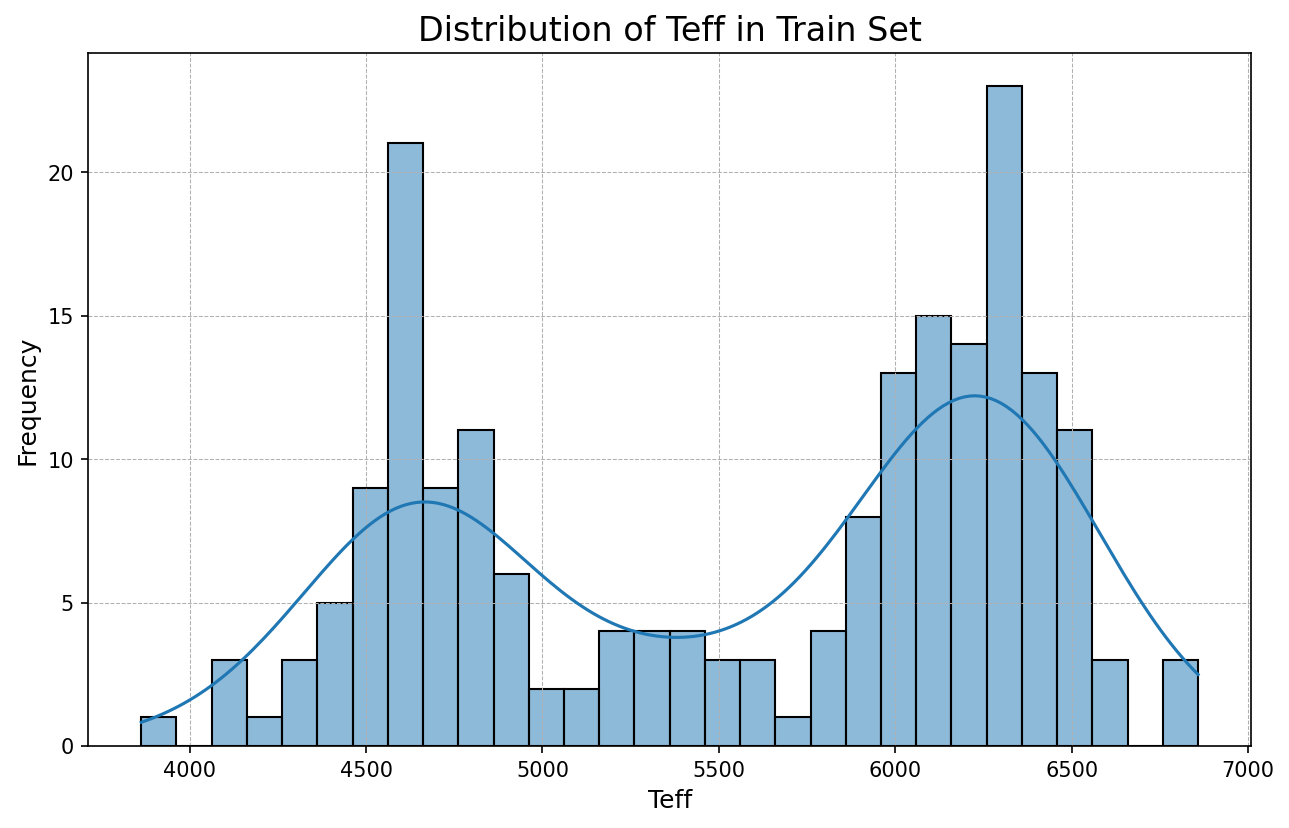

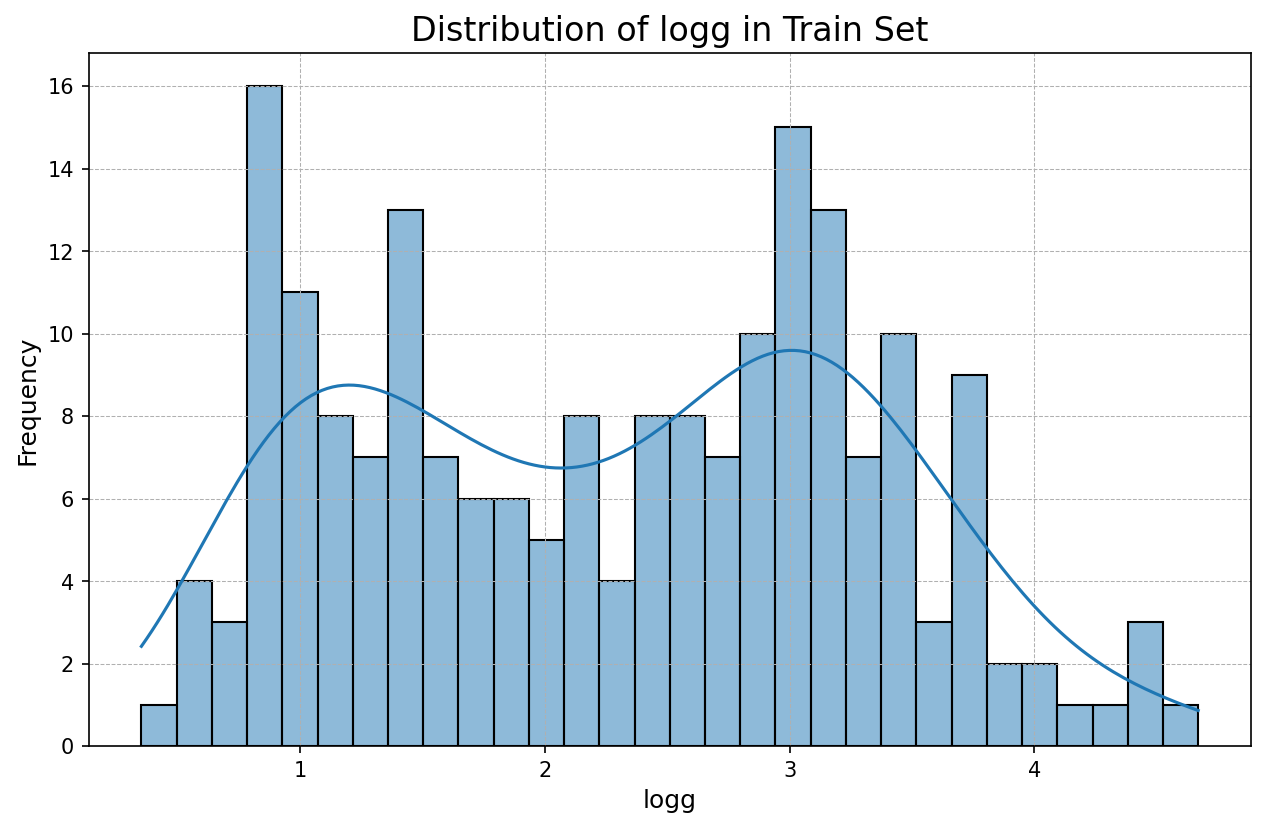

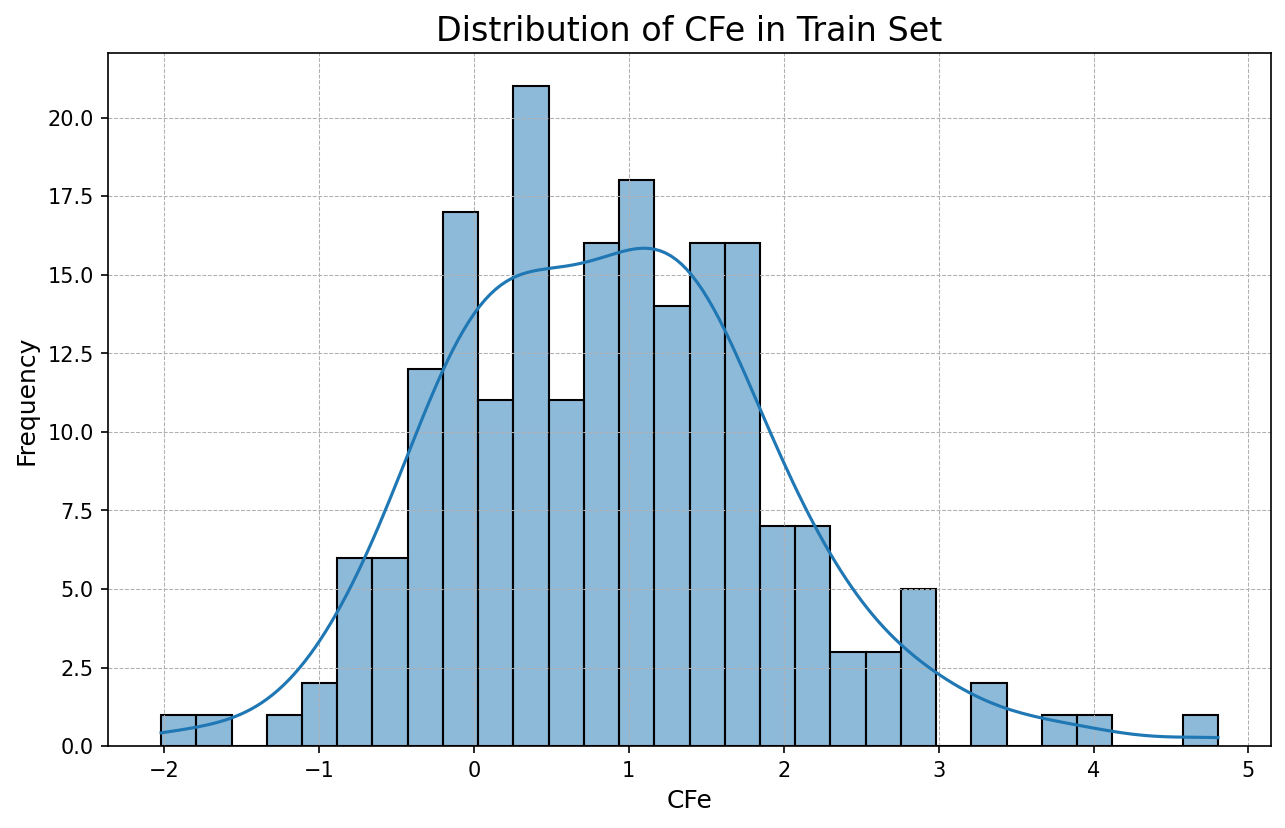

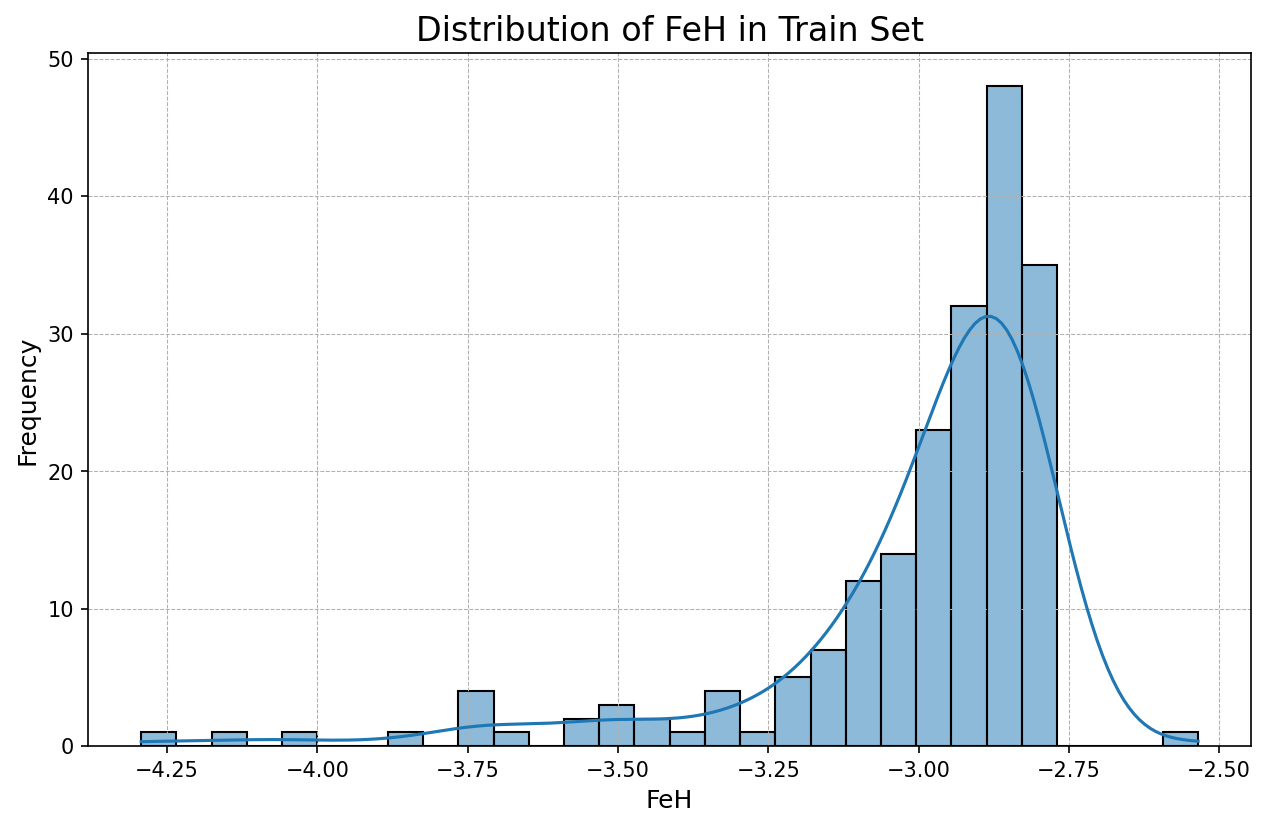

\n--- Val Set Distributions ---


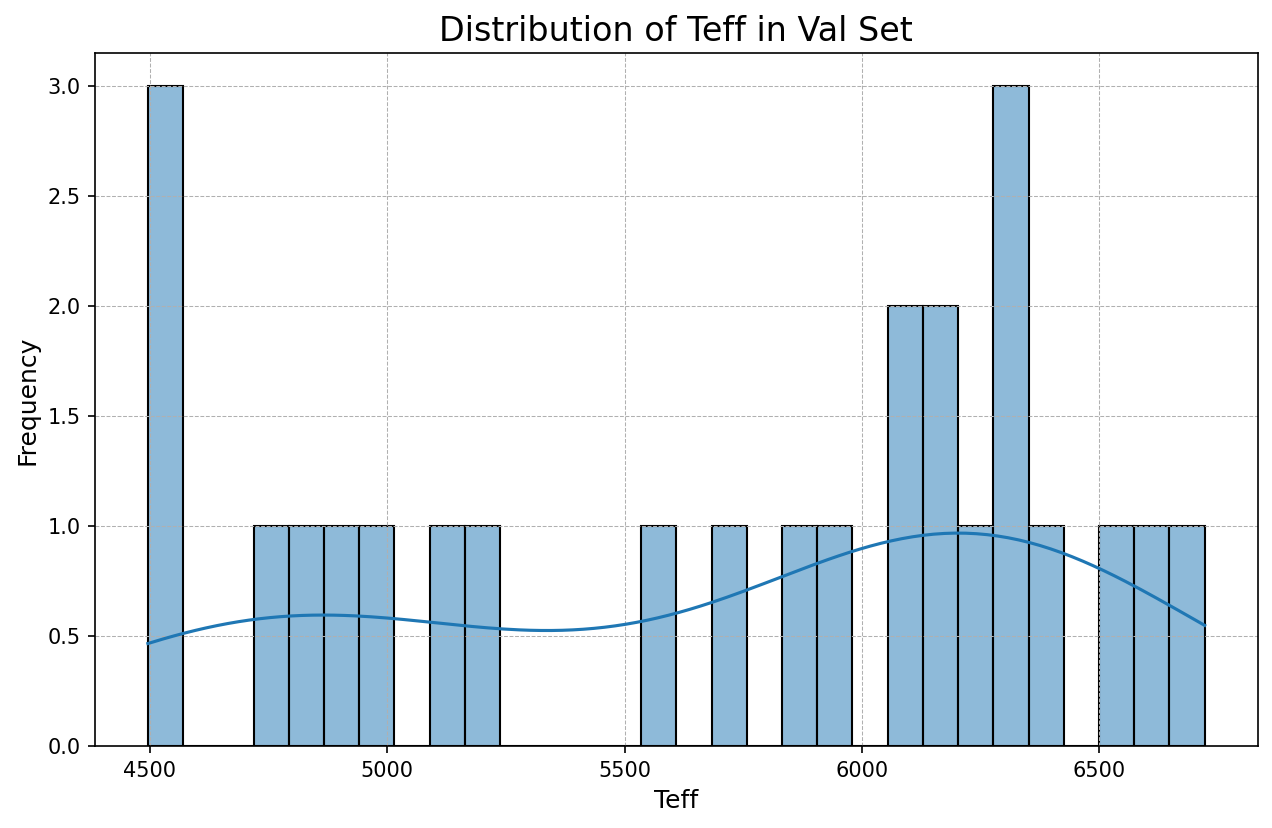

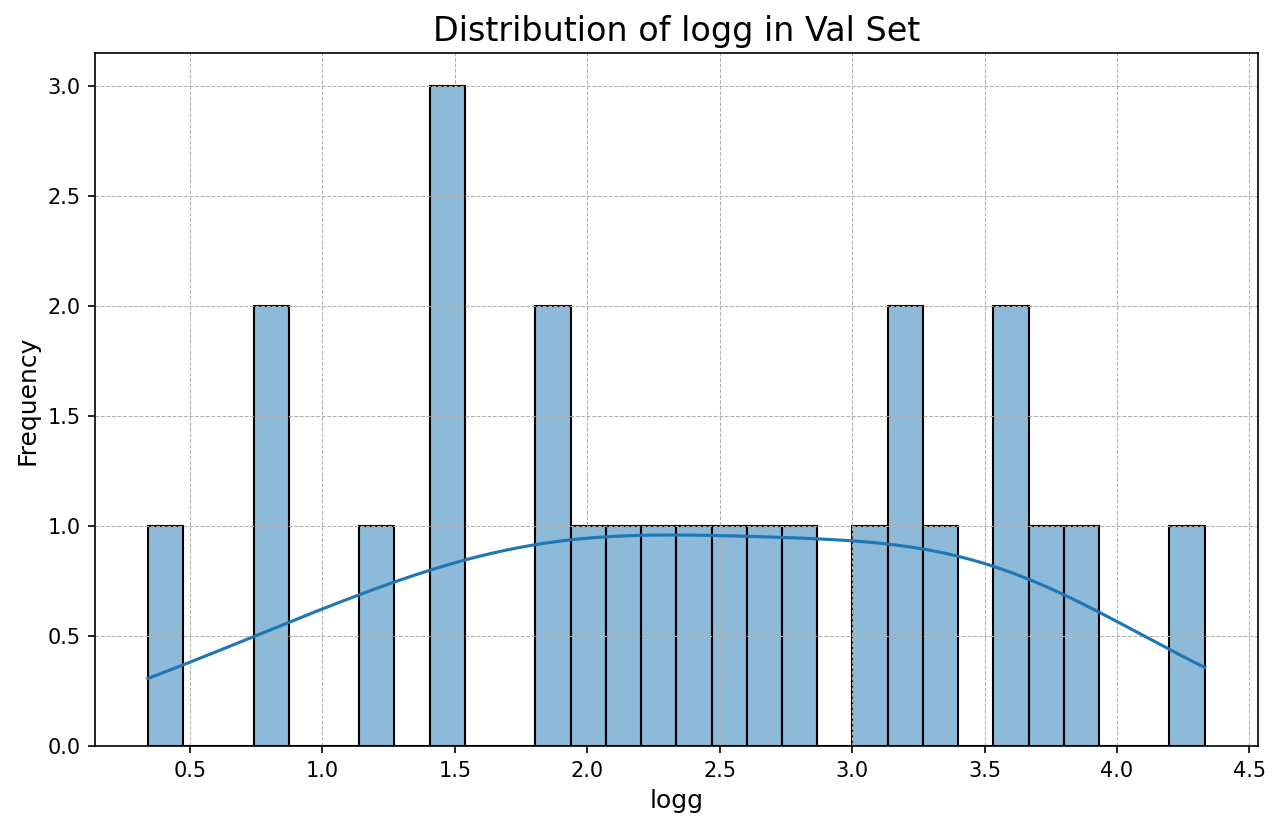

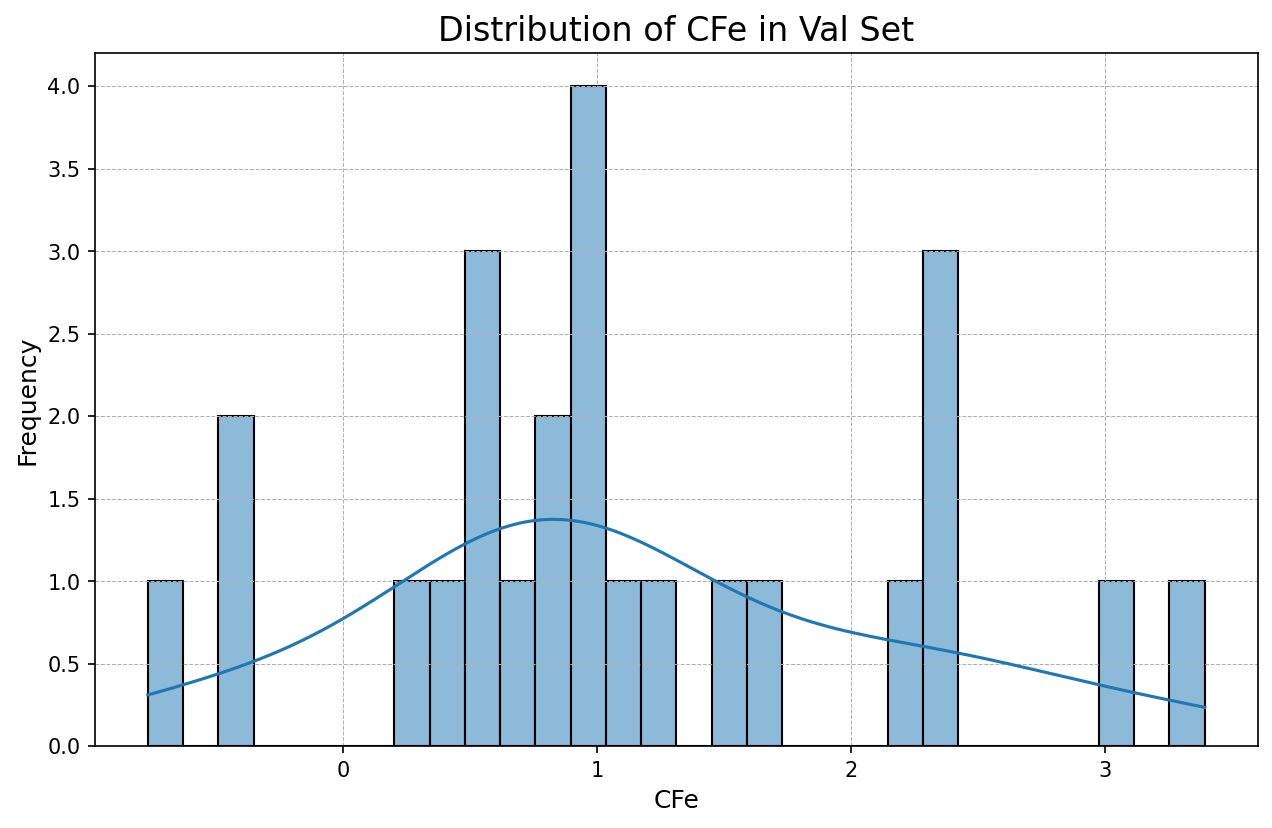

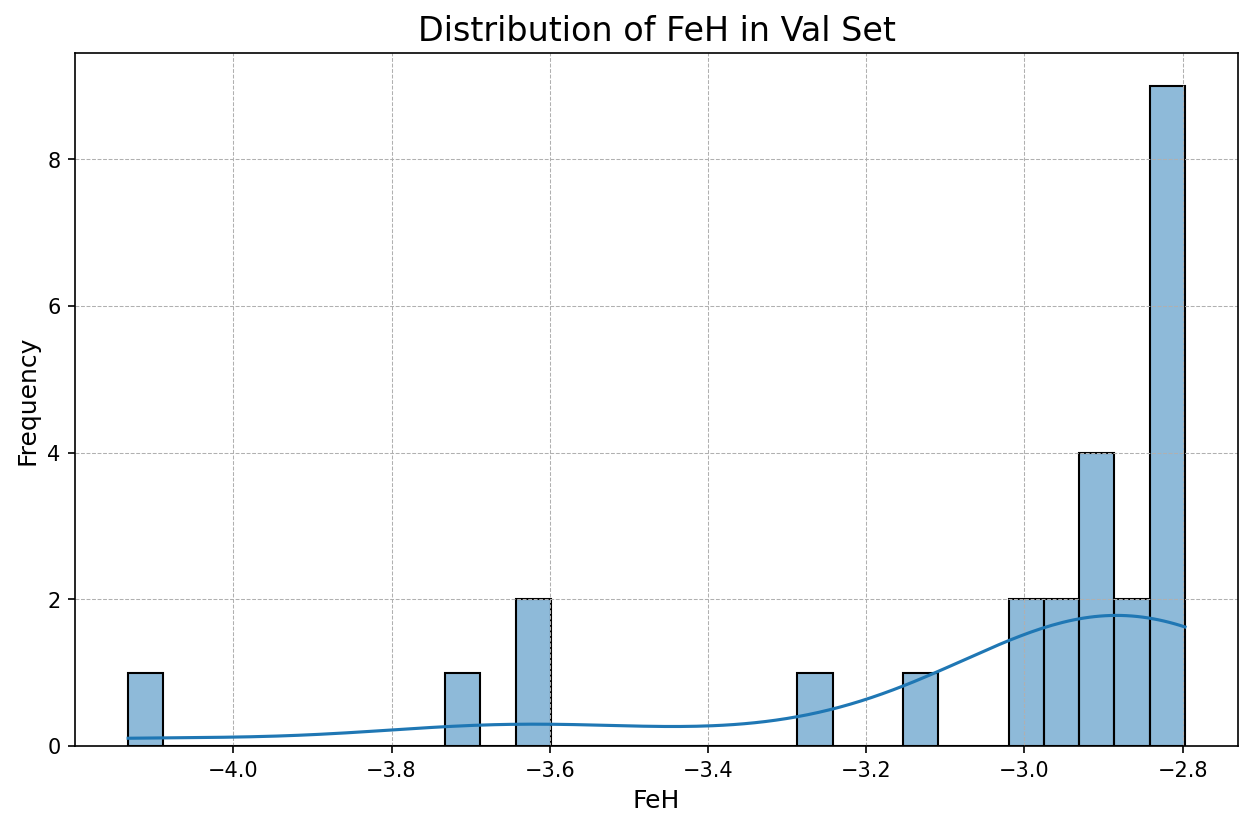

\n--- Test Set Distributions ---


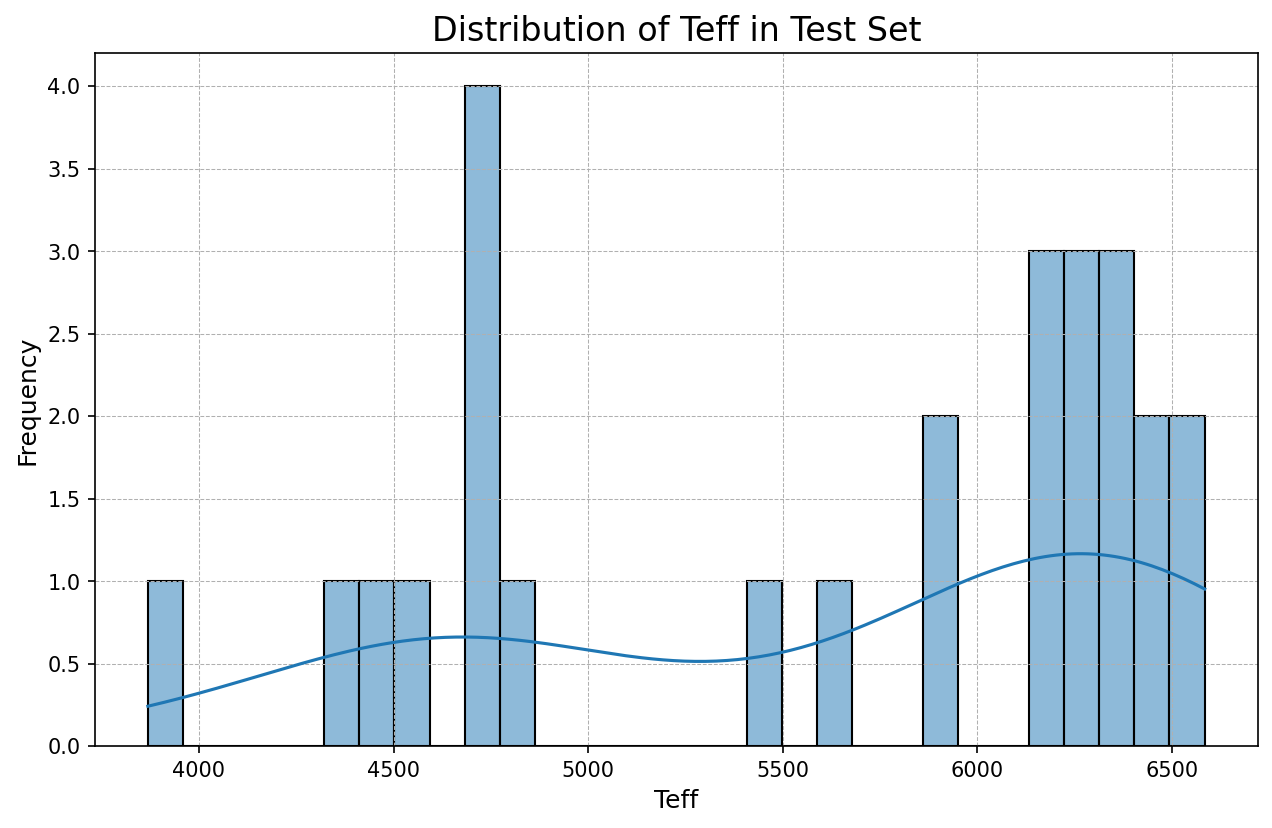

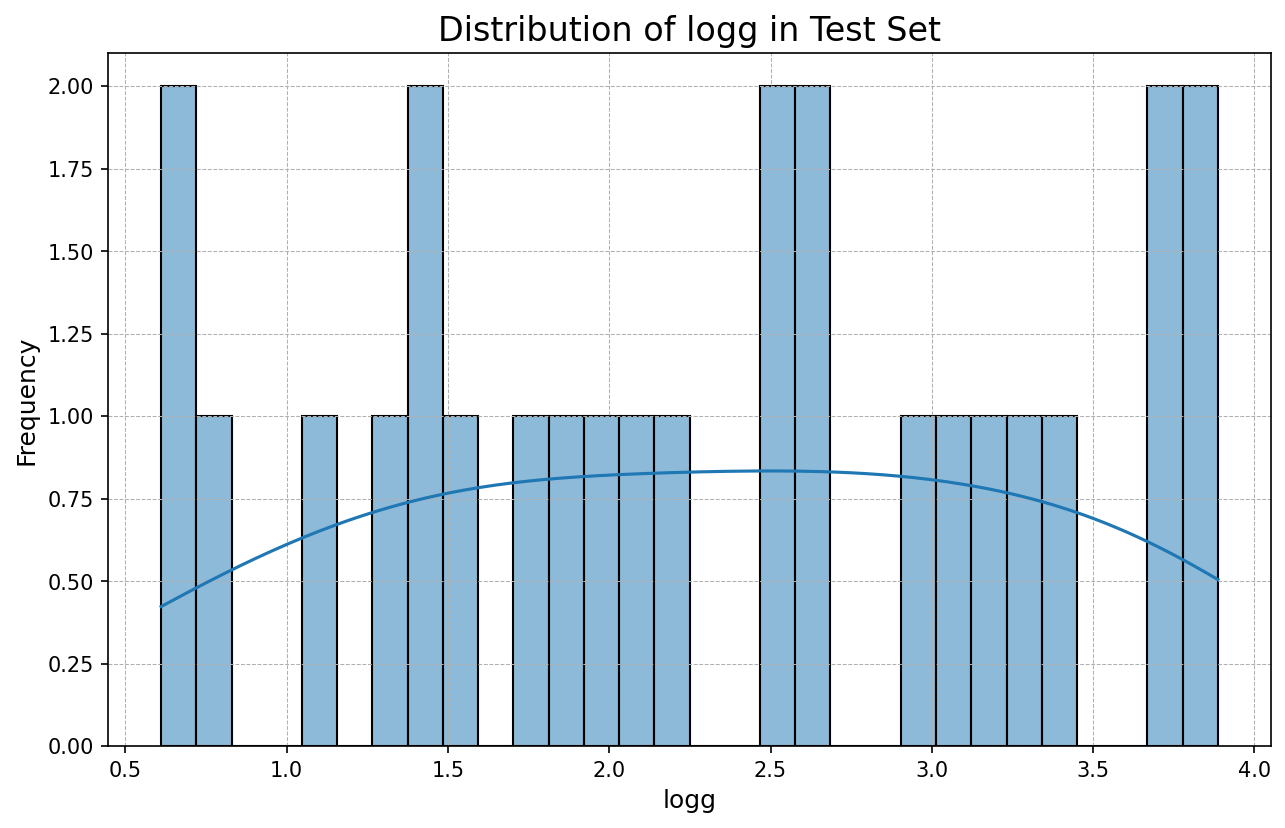

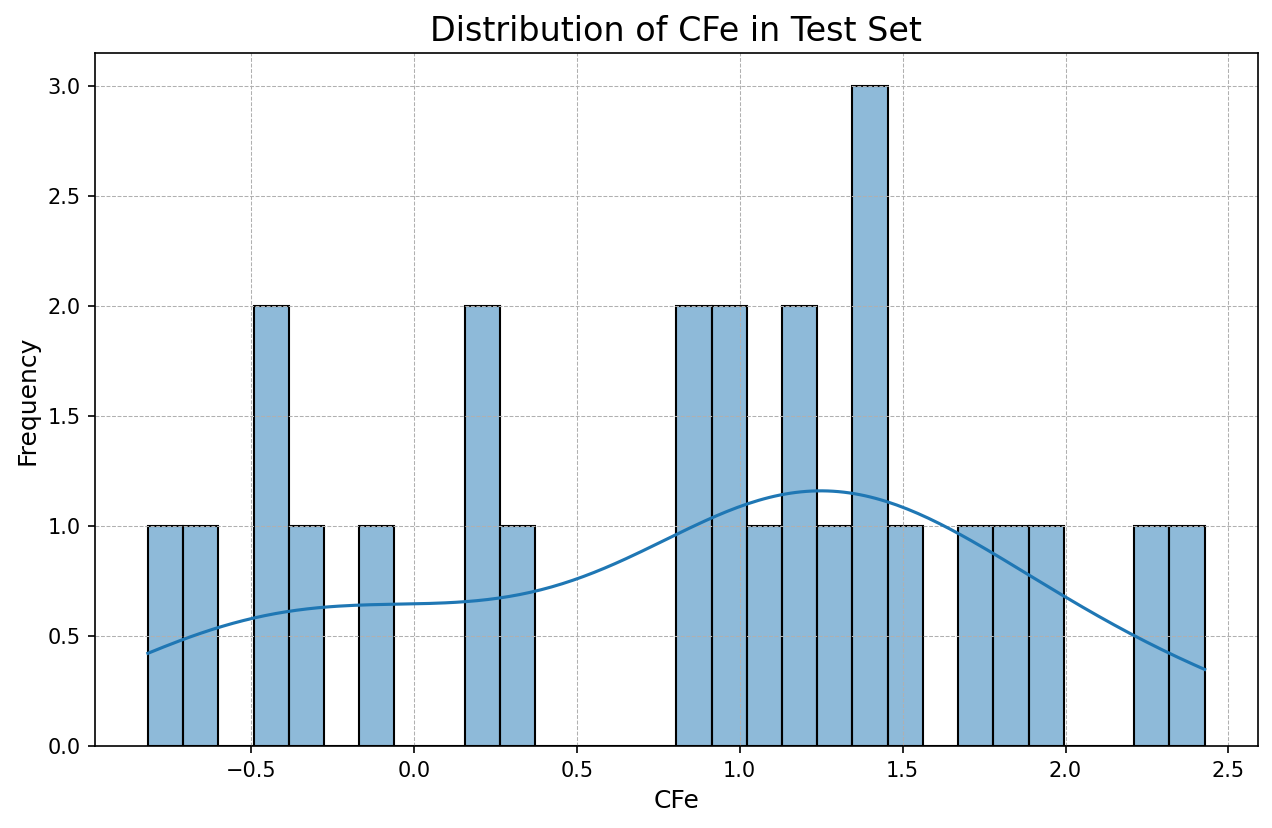

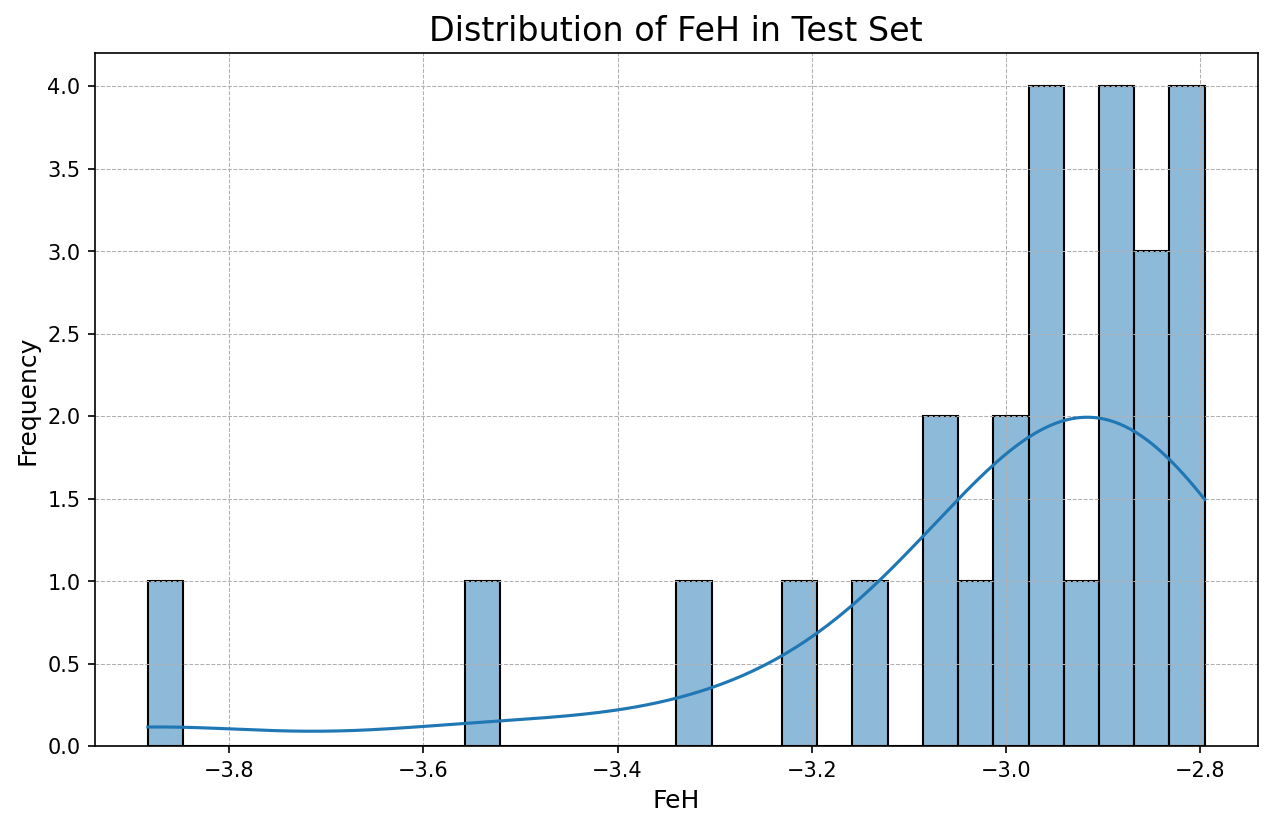

In [11]:
# --- 第四步: 数据集划分与可视化 ---
# (在重采样之后，归一化之前)
from preprocessing_scripts.step6_split_dataset import process_step as split_step
from IPython.display import Image, display
print('--- 开始执行第四步: 数据集划分与可视化 ---')
# 1. 定义输入文件路径
#    输入文件是上一步(重采样)生成的去噪光谱
input_spectra_path = resampled_output_path
labels_filename = 'removed_with_rv_filtered.csv'
output_split_dir = 'split_data_denoized'
    # 2. 调用处理函数
if os.path.exists(input_spectra_path) and os.path.exists(labels_filename):
    split_step(
        resampled_spectra_path=input_spectra_path,
        labels_path=labels_filename,
        output_dir=output_split_dir
    )
    print(f"\\n数据集已成功划分并保存到 \'{output_split_dir}\' 目录中。")
        # 3. 在Notebook中显示生成的分布图
    print("\\n--- 各数据集标签分布图 ---")
    labels_to_plot = ['Teff', 'logg', 'CFe', 'FeH']
    for s in ['train', 'val', 'test']:
        print(f'\\n--- {s.capitalize()} Set Distributions ---')
        set_dir = os.path.join(output_split_dir, s)
        if os.path.exists(set_dir):
            for label in labels_to_plot:
                image_path = os.path.join(set_dir, f'{label}_distribution.png')
                if os.path.exists(image_path):
                    display(Image(filename=image_path))
                else:
                    print(f'未找到 {s} 集的 {label} 分布图。')
        else:
            print(f"未找到 \'{s}\' 数据集目录。")
else:
    print(f"错误：输入文件不存在，无法进行数据集划分。请检查路径: {input_spectra_path},{labels_filename}")
    print('\\n--- 第四步执行完毕 ---')

In [7]:

# --- 连续谱归一化
# 在此单元格中配置归一化策略和相关参数。
# --- 归一化配置 ---
# 可选策略: 'spline_iterative', 'wavelet', 'moving_percentile', 'conv_envelope'
NORM_METHOD = NORM_METHOD

# 为每种归一化策略定义参数
NORM_PARAMS = {
    'spline_iterative': {
        'lower_sigma': 1.5, 
        'upper_sigma': 3.0, 
        'max_iter': 10,     
        'spline_k': 3,      
        'spline_s_factor': 1.0 
    },
    'wavelet': {
        'wavelet': 'db8',   
        'level': 5,         
        'device': 'cuda'   
    },
    'moving_percentile': {
        'window_size': 101, 
        'percentile': 90  ,    
    },
    'conv_envelope': {
        'median_window': 51,    
        'max_window': 51,       
        'smooth_window': 51     
    }
}
from preprocessing_scripts.step4_normalization import process_step as normalize_step

norm_params_for_step = NORM_PARAMS.get(NORM_METHOD, { })

spectra_data_normalized = normalize_step(
    spectra_data_denoised, 
    method=NORM_METHOD, 
    **norm_params_for_step
    )

if SAVE_INTERMEDIATE_FILES:
    utils.save_spectra_to_csv(spectra_data_normalized, os.path.join(OUTPUT_DIR, f'step4_spectra_data_normalized_{NORM_METHOD}.csv'), ['flux_normalized'])
    utils.save_spectra_to_csv(spectra_data_normalized, os.path.join(OUTPUT_DIR, f'step4_spectra_data_continuum_{NORM_METHOD}.csv'), ['continuum'])

utils.visualize_continuum_fit(spectra_data_normalized, obsids_for_visualization, FIGURE_DIR, labels_df=labels_df)
utils.visualize_normalization_step(f'Step4_Normalization_{NORM_METHOD}', spectra_data_normalized, obsids_for_visualization, FIGURE_DIR, labels_df=labels_df)


开始对 264 个光谱进行归一化 (策略: conv_envelope)...
  -> 将对所有连续谱应用平滑处理 (方法: savgol, 窗口: 75)
  正在处理光谱 10/264...
  正在处理光谱 20/264...
  正在处理光谱 30/264...
  正在处理光谱 40/264...
  正在处理光谱 50/264...
  正在处理光谱 60/264...
  正在处理光谱 70/264...
  正在处理光谱 80/264...
  正在处理光谱 90/264...
  正在处理光谱 100/264...
  正在处理光谱 110/264...
  正在处理光谱 120/264...
  正在处理光谱 130/264...
  正在处理光谱 140/264...
  正在处理光谱 150/264...
  正在处理光谱 160/264...
  正在处理光谱 170/264...
  正在处理光谱 180/264...
  正在处理光谱 190/264...
  正在处理光谱 200/264...
  正在处理光谱 210/264...
  正在处理光谱 220/264...
  正在处理光谱 230/264...
  正在处理光谱 240/264...
  正在处理光谱 250/264...
  正在处理光谱 260/264...
归一化完成！
为连续谱拟合生成 5 个指定的可视化样本...
  -> 连续谱拟合图已保存: figures/conv_envelope_none/Step4_ContinuumFit_obsid_298611114.pdf
  -> 连续谱拟合图已保存: figures/conv_envelope_none/Step4_ContinuumFit_obsid_301801138.pdf
  -> 连续谱拟合图已保存: figures/conv_envelope_none/Step4_ContinuumFit_obsid_293502127.pdf
  -> 连续谱拟合图已保存: figures/conv_envelope_none/Step4_ContinuumFit_obsid_78909148.pdf
  -> 连续谱拟合图已保存: figures/conv_envelope_none/Step4_Co

In [8]:

# --- 光谱重采样与格式化
# 在此单元格中配置最终的波长网格。
# --- 重采样配置 ---
# 定义一个或多个波长区间及其采样步长 (Å)。格式: (起始波长, 结束波长, 步长)
WAVELENGTH_CONFIG = [
    (3800, 5700, 1), # 蓝端，较高分辨率采样
    (5900, 8800, 1.5)  # 红端，较低分辨率采样
]
from preprocessing_scripts.step5_resample import process_step as resample_step
import yaml
import numpy as np

# --- 执行重采样与格式化 ---
df_normalized_final, df_continuum_final = resample_step(spectra_data_normalized, WAVELENGTH_CONFIG)

# --- 保存最终的数据产品 ---
utils.save_dataframe_to_csv(df_normalized_final, os.path.join(OUTPUT_DIR, f'final_spectra_normalized_{DENOISE_strategy}_{NORM_METHOD}_{df_normalized_final.shape[1]}.csv'))
utils.save_dataframe_to_csv(df_continuum_final, os.path.join(OUTPUT_DIR, f'final_spectra_continuum_{DENOISE_strategy}_{NORM_METHOD}_{df_normalized_final.shape[1]}.csv'))

# --- 可视化最终产品 ---
print('对最终生成的数据产品进行可视化抽查：')
utils.visualize_final_spectra(df_normalized_final, obsids_for_visualization, FIGURE_DIR, 'Normalized Spectra', labels_df=labels_df)
utils.visualize_final_spectra(df_continuum_final, obsids_for_visualization, FIGURE_DIR, 'Continuum Spectra', labels_df=labels_df)


开始对 264 个光谱进行重采样和格式化...
  -> 已生成包含 3834 个数据点的最终波长网格。
  正在处理光谱 10/264...
  正在处理光谱 20/264...
  正在处理光谱 30/264...
  正在处理光谱 40/264...
  正在处理光谱 50/264...
  正在处理光谱 60/264...
  正在处理光谱 70/264...
  正在处理光谱 80/264...
  正在处理光谱 90/264...
  正在处理光谱 100/264...
  正在处理光谱 110/264...
  正在处理光谱 120/264...
  正在处理光谱 130/264...
  正在处理光谱 140/264...
  正在处理光谱 150/264...
  正在处理光谱 160/264...
  正在处理光谱 170/264...
  正在处理光谱 180/264...
  正在处理光谱 190/264...
  正在处理光谱 200/264...
  正在处理光谱 210/264...
  正在处理光谱 220/264...
  正在处理光谱 230/264...
  正在处理光谱 240/264...
  正在处理光谱 250/264...
  正在处理光谱 260/264...
光谱重采样和格式化完成！
  -> 最终数据产品已保存到: files/final_spectra_normalized_none_conv_envelope_3834.csv
  -> 最终数据产品已保存到: files/final_spectra_continuum_none_conv_envelope_3834.csv
对最终生成的数据产品进行可视化抽查：
为最终数据产品 'Normalized Spectra' 生成 5 个可视化样本...
  -> 最终产品可视化图表已保存: figures/conv_envelope_none/Final_Spectrum_Normalized Spectra_obsid_298611114.pdf
  -> 最终产品可视化图表已保存: figures/conv_envelope_none/Final_Spectrum_Normalized Spectra_obsid_301801138.pdf
  -> 最终产品

In [9]:

# --- 计算全面的统计数据 ---
print('开始计算连续谱的全面统计数据...')
numeric_df = df_continuum_final.select_dtypes(include=np.number)
all_values = numeric_df.values.flatten()

# 计算统计量
stats = {
    'mean': float(np.mean(all_values)),
    'variance': float(np.var(all_values)),
    'std_dev': float(np.std(all_values)),
    'min': float(np.min(all_values)),
    'max': float(np.max(all_values)),
    '25th_percentile': float(np.percentile(all_values, 25)),
    'median_50th_percentile': float(np.median(all_values)),
    '75th_percentile': float(np.percentile(all_values, 75))
}

# 保存到YAML文件
stats_file_path = os.path.join(OUTPUT_DIR, f'continuum_stats_{DENOISE_strategy}_{NORM_METHOD}_{df_normalized_final.shape[1]}.yaml')
with open(stats_file_path, 'w') as f:
    yaml.dump(stats, f, default_flow_style=False, sort_keys=False)

print(f"连续谱的统计数据已保存到: {stats_file_path}")

print('流水线所有步骤执行完毕！')

# --- 计算全面的统计数据 ---
print('开始计算吸收线谱的全面统计数据...')
numeric_df = df_normalized_final.select_dtypes(include=np.number)
all_values = numeric_df.values.flatten()

# 计算统计量
stats = {
    'mean': float(np.mean(all_values)),
    'variance': float(np.var(all_values)),
    'std_dev': float(np.std(all_values)),
    'min': float(np.min(all_values)),
    'max': float(np.max(all_values)),
    '25th_percentile': float(np.percentile(all_values, 25)),
    'median_50th_percentile': float(np.median(all_values)),
    '75th_percentile': float(np.percentile(all_values, 75))
}

# 保存到YAML文件
stats_file_path = os.path.join(OUTPUT_DIR, f'normalized_stats_{DENOISE_strategy}_{NORM_METHOD}_{df_normalized_final.shape[1]}.yaml')
with open(stats_file_path, 'w') as f:
    yaml.dump(stats, f, default_flow_style=False, sort_keys=False)

print(f"连续谱的统计数据已保存到: {stats_file_path}")

开始计算连续谱的全面统计数据...
连续谱的统计数据已保存到: files/continuum_stats_none_conv_envelope_3834.yaml
流水线所有步骤执行完毕！
开始计算吸收线谱的全面统计数据...
连续谱的统计数据已保存到: files/normalized_stats_none_conv_envelope_3834.yaml


In [10]:
# --- 数据集划分 ---
# 调用脚本，根据FeH值对数据集进行分层抽样划分
print('开始进行数据集划分...')
# 首先，获取上一步生成的文件名
continuum_filename = os.path.join(OUTPUT_DIR, f'final_spectra_continuum_{DENOISE_strategy}_{NORM_METHOD}_{df_normalized_final.shape[1]}.csv')
normalized_filename = os.path.join(OUTPUT_DIR, f'final_spectra_normalized_{DENOISE_strategy}_{NORM_METHOD}_{df_normalized_final.shape[1]}.csv')
labels_filename = 'removed_with_rv_filtered.csv'
output_split_dir = 'split_data'

from preprocessing_scripts.split_dataset_by_feh import split_dataset_by_feh
split_dataset_by_feh(continuum_filename,normalized_path=normalized_filename,labels_path=labels_filename,output_dir=output_split_dir)
# 构建并执行命令
# command = f'python3 preprocessing_scripts/split_dataset_by_feh.py --continuum_path {continuum_filename} --normalized_path {normalized_filename} --labels_path {labels_filename} --output_dir {output_split_dir}'
# print(f'Executing: {command}')
# !{command}
# print('数据集划分完成！')

开始进行数据集划分...
Loading datasets...
Datasets loaded successfully.
Train set size: 199
Validation set size: 25
Test set size: 26
Ensuring consistent order of samples across all files...
Plotting distributions for train set...
  -> Saved Teff distribution plot to split_data/train/Teff_distribution.png
  -> Saved logg distribution plot to split_data/train/logg_distribution.png
  -> Saved CFe distribution plot to split_data/train/CFe_distribution.png
  -> Saved FeH distribution plot to split_data/train/FeH_distribution.png
Plotting distributions for val set...
  -> Saved Teff distribution plot to split_data/val/Teff_distribution.png
  -> Saved logg distribution plot to split_data/val/logg_distribution.png
  -> Saved CFe distribution plot to split_data/val/CFe_distribution.png
  -> Saved FeH distribution plot to split_data/val/FeH_distribution.png
Plotting distributions for test set...
  -> Saved Teff distribution plot to split_data/test/Teff_distribution.png
  -> Saved logg distribution plot 